## Exercise 3: The 2D Ising model
Aim: construct a 2D Ising model and use it to measure the thermodynamic and magnetic properties of the system as a function of time and as a function of the temperature and magnetic field.

In [1]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import k
from tqdm import tqdm

Metropolis-Hastings algorithm
1. Pick a spin site randomly and calculate the contribution to the energy involving this spin.
2. Flip the value of the spin and calculate the new contribution.
3. If the new energy is less, keep the flipped value.
4. If the new energy is more, only keep with probability  $e^{-\beta (H_{\nu }-H_{\mu })}.$
Repeat

In [10]:
# Define the functions required for the Ising model numerical experiment

# Define custom colormap
cmap = plt.cm.colors.ListedColormap(['white', 'black'])
norm = plt.cm.colors.Normalize(vmin=-1, vmax=1)

# Create a wxw grid of randonly assinged 0 or 1
def generate_grid(w, type):
    if type == "rand":
        grid = np.random.randint(2, size=(w, w))
        grid[grid == 0] = -1
    elif type == "up":
        grid = np.zeros((w,w)) + 1
    elif type == "down":
        grid = np.zeros((w,w)) - 1
    return grid

# Calculate energy
def calculate_energy(grid, coupling, field):
    left = np.roll(grid, -1, axis=1)
    right = np.roll(grid, 1, axis=1)
    bottom = np.roll(grid, 1, axis=0)
    top = np.roll(grid, -1, axis=0)
    sum_neighbours = left + right + top + bottom
    energy = -1 * coupling * grid * sum_neighbours - field * grid  
    return energy

# Metropolis-Hastings algorithm
def metropolis_hastings_algorithm(w, grid, coupling, field, mask):
    initial_energy = calculate_energy(grid, coupling, field)
    # flipped 
    flipped_grid = np.where(mask, grid * -1, grid)
    final_energy = calculate_energy(flipped_grid, coupling, field)
    delta_energy = final_energy - initial_energy
    
    energy_lower = delta_energy < 0
    energy_higher = delta_energy > 0

   # If the energy is lower, flip the spin
    updated_grid = np.where(energy_lower, flipped_grid, grid)
    # If the energy is higher, keep the flip state with probability exp(-delta_energy)
    Boltzmann_p = np.exp(-delta_energy)
    updated_grid = np.where(energy_higher & (np.random.rand(w,w) < Boltzmann_p), flipped_grid, updated_grid)
    return updated_grid

# Compute the magnetization
def compute_magnetization(grid):
    return np.sum(grid) / grid.size

# Compute energy fluctuation of system
def compute_energy_fluctuation(grid, coupling, field):
    energy = calculate_energy(grid, coupling, field)
    return np.std(energy)

# Run the simulation
def run_simulation(w, 
                   coupling, 
                   field, 
                   steps, 
                   type, 
                   plot=True, 
                   grid=None, 
                   check_equilibrium=False):
    
    n = int(np.floor(np.log10(steps)))
    # Generate grid if not provided
    if grid is None:
        grid = generate_grid(w, type)

    if plot:
        fig, ax = plt.subplots(1, n+1, figsize=(20, 5))

    # time steps to plot (powers of 10)
    t_list = [10**i for i in range(n+1)]

    magnetisation = []
    # Define masks for even and odd sites (speeding up the simulation using the checkerboard decomposition)
    even_mask = np.indices((w,w)).sum(axis=0) % 2
    odd_mask = (even_mask + 1) % 2  

    # iterate through
    for t in tqdm(range(steps+1)):
        magnetisation.append(compute_magnetization(grid))
        grid = metropolis_hastings_algorithm(w, grid, coupling, field, even_mask)
        grid = metropolis_hastings_algorithm(w, grid, coupling, field, odd_mask)
        
        # Plotting the results at the specified timesteps
        if plot:  
            if t in t_list:
                i = t_list.index(t)
                ax[i].matshow(grid, cmap=cmap, norm=norm)
                ax[i].set_title(f"t={t}")
        if check_equilibrium:
            try:
                diff = np.diff(magnetisation[-5:])
                percentage_change = abs(diff/magnetisation[-5])
                if np.mean(percentage_change) < 0.005:
                    break
            except IndexError:
                pass
    if plot:
        plt.show()
            
    return magnetisation, grid

### Core Task 1: no spin coupling

coupling, $\beta J = 0$ and field, $\beta \mu H \in (-3,3)$


100%|██████████| 501/501 [00:05<00:00, 98.75it/s] 


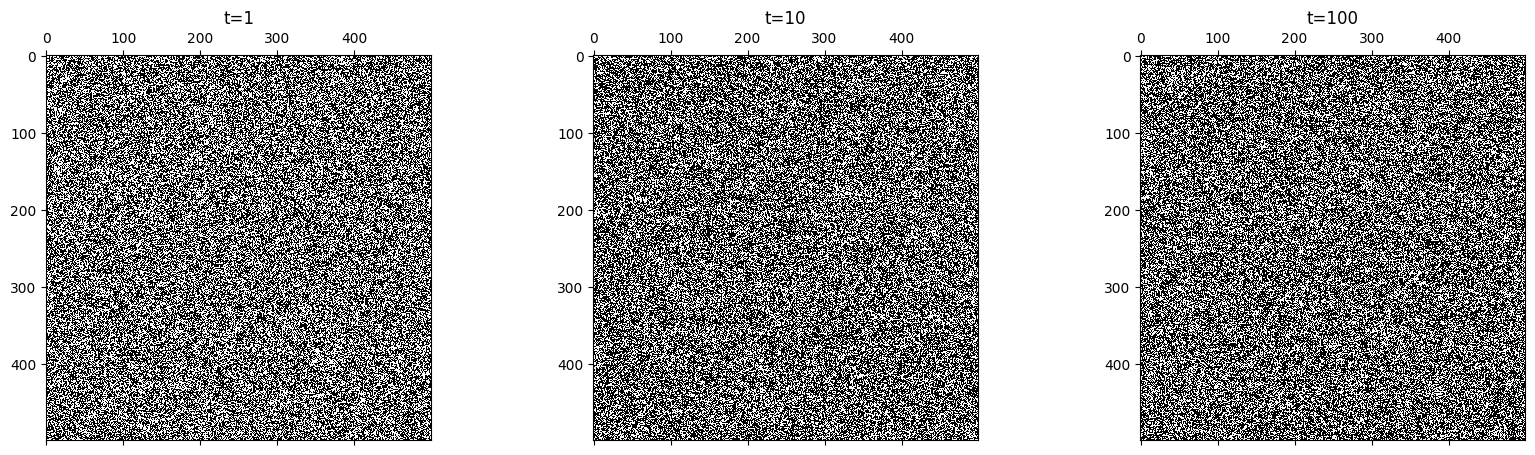

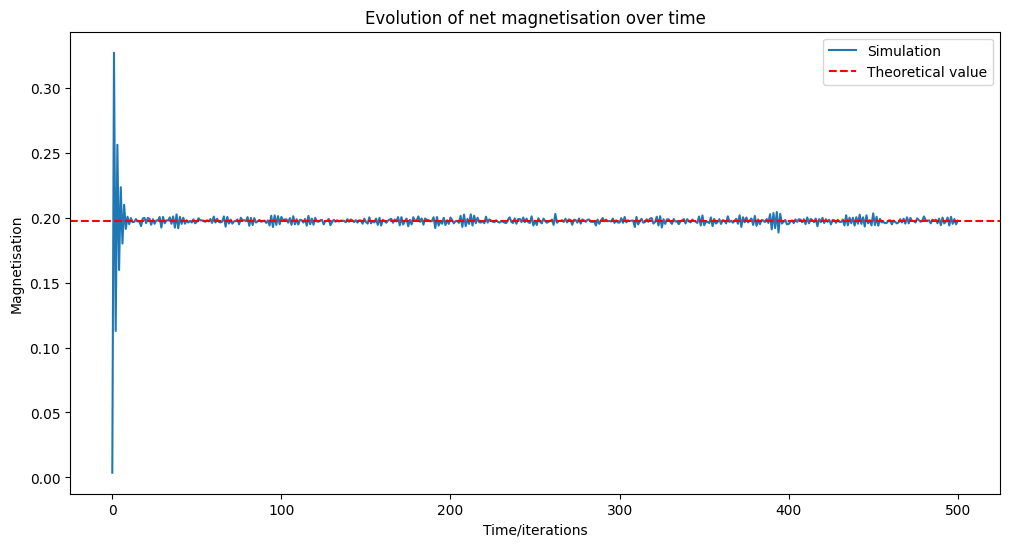

In [11]:
# Physical parameters
coupling, field = 0, 0.2 # interaction strength and magnetic field

# Simulation setup
w = 500 # grid size
steps = 500 # max time steps in terms of 10^n

magnetisation, grid = run_simulation(w, coupling, field, steps, "rand", plot=True)

# Plot the magnetisation over time
plt.figure(figsize=(12,6))
plt.plot(range(len(magnetisation)), magnetisation, label="Simulation")
plt.axhline(np.tanh(field), label="Theoretical value", color="r", linestyle="--")
plt.xlabel("Time/iterations")
plt.ylabel("Magnetisation")
plt.title("Evolution of net magnetisation over time")
plt.legend()
plt.show()

In [ ]:
# Physical parameters
coupling = 0 # interaction strength 
field_list = np.linspace(-3,3,20)

# Simulation setup
w = 200 # grid size
steps = 1000 # max time steps in terms of 10^n

# Run the simulation
M = {}

for field in field_list:
    magnetisation, grid = run_simulation(w,coupling, field, steps,  "rand", plot=False)
    M[field] = magnetisation[-1]



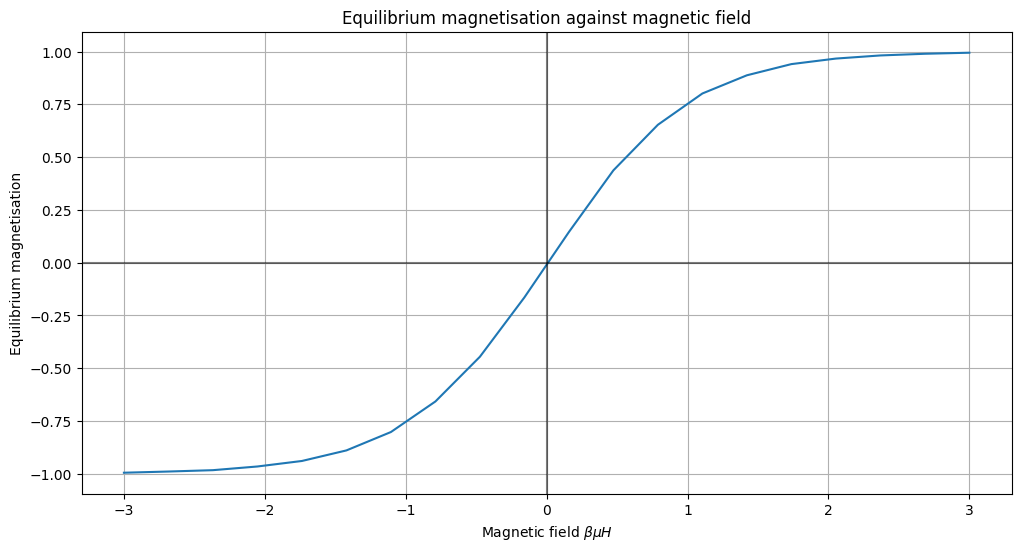

In [175]:
# Plot the magnetisation against field
plt.figure(figsize=(12,6))
plt.plot(field_list, list(M.values()), label="Simulation")
plt.axhline(0, color="k", alpha=0.5)
plt.axvline(0, color="k", alpha=0.5)
plt.title("Equilibrium magnetisation against magnetic field")
plt.ylabel("Equilibrium magnetisation")
plt.xlabel(r"Magnetic field $\beta \mu H$")
plt.grid()

#### Conclusion (Core task 1):
- The Monte Carlo method converges to the analytical solution after sufficient iterations
- A plot of equilibrium magnetisation against field shows the expected magnetisation curve.

### Core task 2: only spin coupling

coupling, $\beta J = 0.2 \text{ or } -0.2$ and field, $\beta \mu H = 0$


Analytical solution discovered by Lars Onsanger:
$$
\langle M \rangle = \begin{cases} 0 & , \;\text{if } \beta J \le \frac{1}{2}\ln(1+\sqrt{2})\\
\pm (1-\sinh(2\beta J)^{-4})^{\frac{1}{8}}& ,\;\text{if } \beta J >\frac{1}{2}\ln(1+\sqrt{2})
\end{cases}
$$
where the critical temperature happens when $\beta J = \frac{1}{2}\ln(1+\sqrt{2}) \approx 0.44$. 

In [101]:
def Lars_Onsanger(coupling):
    if coupling <= 1/2 * (np.log(1+np.sqrt(2))):
        return 0
    else:
        return (1-(np.sinh(2*coupling))**(-1*4))**(1/8)

100%|██████████| 10001/10001 [00:19<00:00, 504.54it/s]


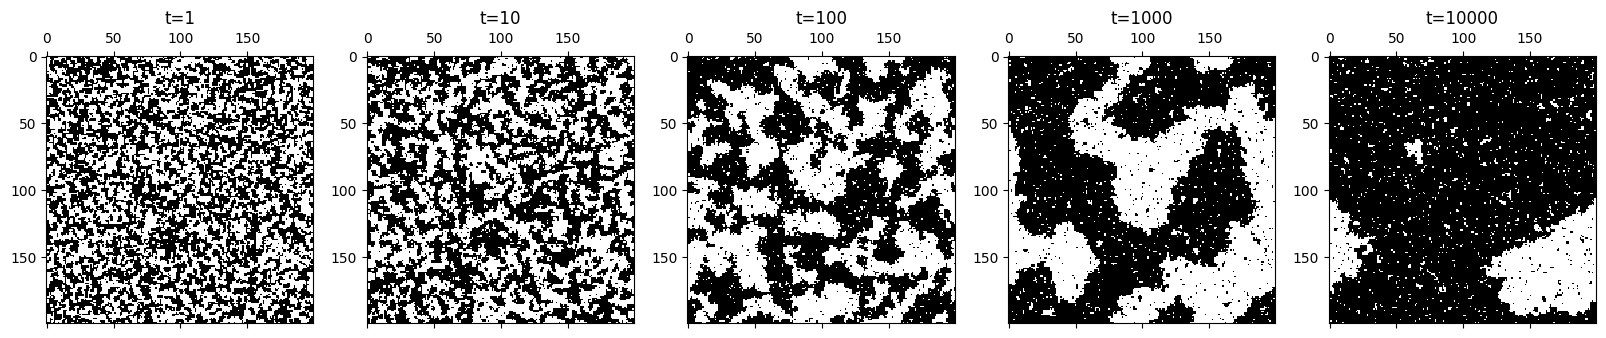

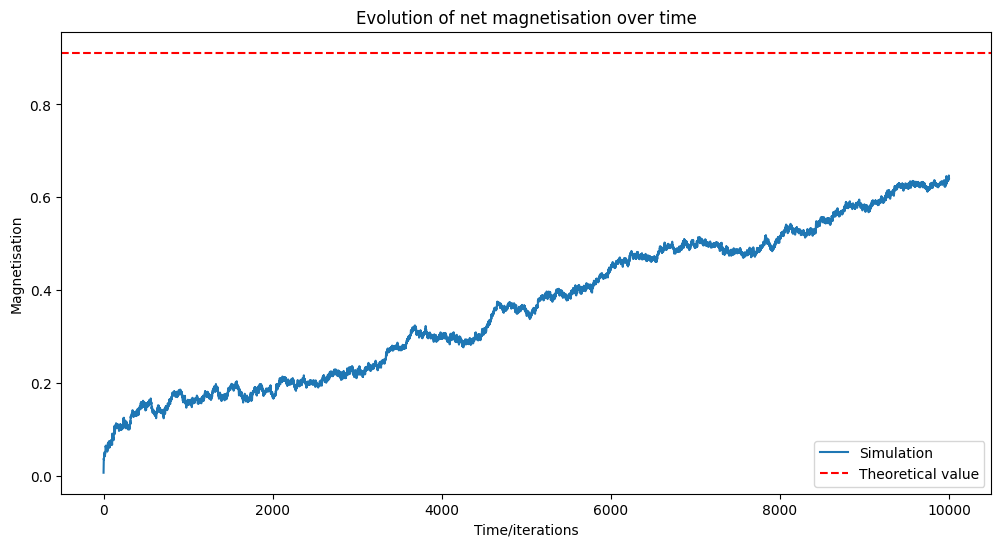

In [109]:
# Physical parameters
coupling, field = 0.5, 0 # interaction strength and magnetic field

# Simulation setup
w = 200 # grid size
steps = 10000

# Run the simulation
magnetisation, grid = run_simulation(w, coupling, field, steps,  "rand", plot=True)
# plt.matshow(grid, cmap=cmap, norm=norm)
# plt.show()

# Plot the magnetisation over time
plt.figure(figsize=(12,6))
plt.plot(range(len(magnetisation)), magnetisation, label="Simulation")
if magnetisation[-1] > 0:
    plt.axhline(Lars_Onsanger(coupling), label="Theoretical value", color="r", linestyle="--")
else:
    plt.axhline(Lars_Onsanger(coupling)*-1, label="Theoretical value", color="r", linestyle="--")
plt.xlabel("Time/iterations")
plt.ylabel("Magnetisation")
plt.title("Evolution of net magnetisation over time")
plt.legend()
plt.show()

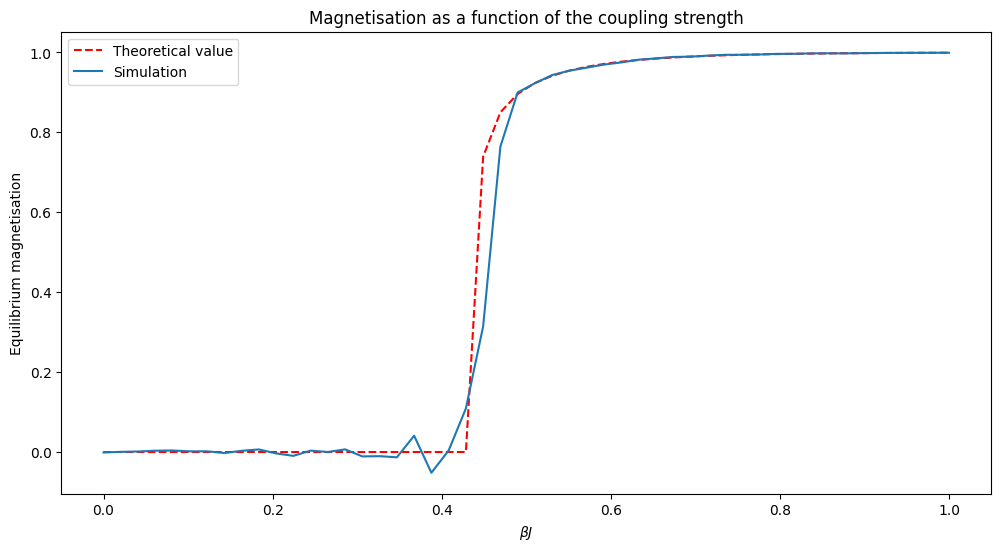

In [157]:
# Plotting the outputs
coupling = np.linspace(0, 1, 50)
analytical_magnetisation = [Lars_Onsanger(c) for c in coupling]
simulation_magnetisation = np.load("task2_magnetisation.npy")

plt.figure(figsize=(12,6))
if simulation_magnetisation[-1] > 0:
    plt.plot(coupling, analytical_magnetisation, label="Theoretical value", color="r", linestyle="--")
else:
    plt.plot(coupling, np.multiply(analytical_magnetisation, -1),label="Theoretical value", color="r", linestyle="--")

plt.plot(coupling, simulation_magnetisation,label="Simulation")
plt.ylabel("Equilibrium magnetisation")
plt.legend()
plt.xlabel(r"$\beta J$")
plt.title("Magnetisation as a function of the coupling strength")
plt.show()

### Conclusion (Core task 2):
- The Monte Carlo method correctly reproduces the analytical Lars Onsanger solution
- Around the critical point, there is a sharp jump in equilibrium magnetisaion

### 3. Supplementary task
$$
C = \frac{\sigma_E^2 }{k_B T^2} = \sigma_E^2 \beta^2k_B = \frac{k_B}{J^2} \times (\sigma_E \beta J)^2 \propto [\sigma_E \times (\beta J)]^2
$$

In [12]:
def heat_capacity(sigma_E, coupling):
    return (sigma_E * coupling)**2

# Interaction strength and magnetic field
field = 0
coupling = np.linspace(0.3, 0.7, 50)

w_list = [32, 64, 128, 256]
steps = 20000

# Run the simulation
heat_capacities = {}
for w in w_list:
    grid = generate_grid(w, "rand")
    heat_capacities[w] = []
    for c in coupling:
        magnetisation, grid = run_simulation(w, c, field, steps,  "rand", plot=False, grid=grid)
        sigma_E = compute_energy_fluctuation(grid, c, field)
        heat_capacities[w].append(heat_capacity(sigma_E, c))

100%|██████████| 20001/20001 [00:54<00:00, 366.69it/s]


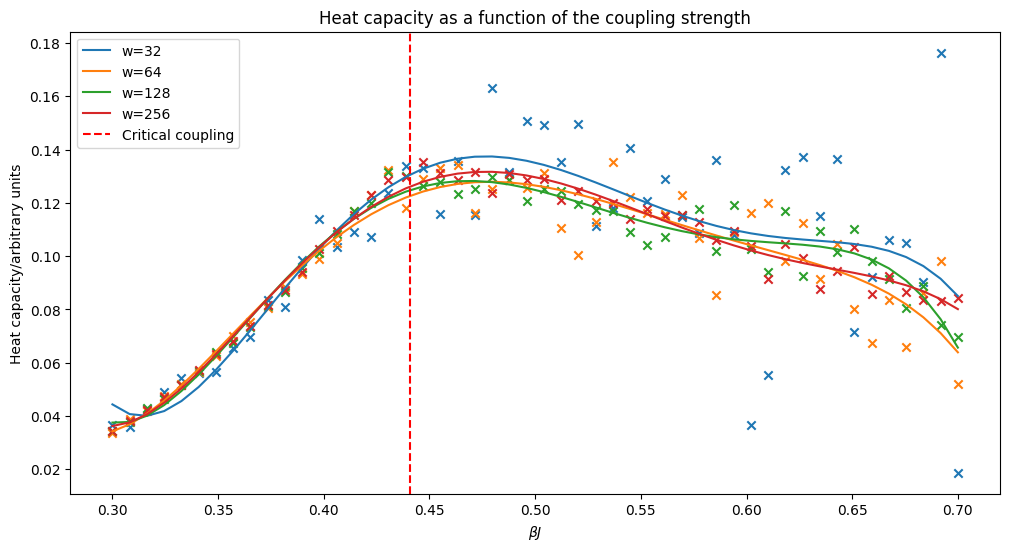

In [14]:

coupling = np.linspace(0.3, 0.7, 50)
plt.figure(figsize=(12,6))
for key, value in heat_capacities.items():
    # draw best-fit line for the data
    z = np.polyfit(coupling, value, 5)
    p = np.poly1d(z)
    plt.plot(coupling, p(coupling), label=f"w={key}")
    plt.scatter(coupling, value, marker="x")

plt.axvline(1/2 * (np.log(1+np.sqrt(2))), label="Critical coupling", color="r", linestyle="--")
plt.xlabel(r"$\beta J$")
plt.ylabel("Heat capacity/arbitrary units")
plt.title("Heat capacity as a function of the coupling strength")
plt.legend()
plt.show()

In [15]:
np.save("heat_capacity.npy", heat_capacities)

In [148]:
heat_capacities = np.load("heat_capacity_data.npz", allow_pickle=True)

#### Conclusion (Supplementary task):
- The heat capacity peaks sharply at the critical temperature $\beta J \approx 0.44$ for all lattice sizes.
- The greater the number of lattice sites, the sharper it peaks.